In [2]:
from nilearn import datasets
import pandas as pd
from nilearn import plotting
from nilearn.interfaces.fmriprep import load_confounds_strategy,load_confounds
from pathlib import Path
from nilearn.image import load_img,clean_img
from nilearn.maskers import NiftiLabelsMasker
import os
from nilearn.interfaces.fmriprep import load_confounds_strategy
from nilearn.maskers import NiftiMapsMasker,NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
import numpy as np
from nilearn.datasets import fetch_atlas_schaefer_2018
from multiprocessing.pool import Pool
import matplotlib.pyplot as plt

In [3]:
# data_path ='/workspace/mnt/data/hcp_task_base/'
data_path ='/workspace/mnt/public-datasets/m.zubrikhina/hcp_rest2/'

In [4]:
os.listdir(data_path)

['779370',
 '208630',
 '620434',
 '287248',
 '150423',
 '200311',
 '453542',
 '992673',
 '217126',
 '613538',
 '877269',
 '102816',
 '415837',
 '757764',
 '163432',
 '150625',
 '102614',
 '463040',
 '219231',
 '182032',
 '715647',
 '110411',
 '110613',
 '616645',
 '147030',
 '413934',
 '298455',
 '766563',
 '185038',
 '114217',
 '197348',
 '559457',
 '677766',
 '555954',
 '180230',
 '729557',
 '135124',
 '480141',
 '465852',
 '588565',
 '929464',
 '436845',
 '141119',
 '201717',
 '429040',
 '705341',
 '117930',
 '119732',
 '130518',
 '134223',
 '468050',
 '268749',
 '387959',
 '171431',
 '598568',
 '136126',
 '969476',
 '165234',
 '568963',
 '100408',
 '902242',
 '159845',
 '162026',
 '809252',
 '555651',
 '497865',
 '187850',
 '753150',
 '185442',
 '119025',
 '901442',
 '130316',
 '171330',
 '124826',
 '467351',
 '195041',
 '852455',
 '186949',
 '459453',
 '175136',
 '168947',
 '522434',
 '202719',
 '524135',
 '880157',
 '214423',
 '469961',
 '859671',
 '613235',
 '188448',
 '202113',

In [5]:
atlas =fetch_atlas_schaefer_2018()

In [6]:
atlas['labels'].shape

(400,)

In [7]:
def extract_correlation_pipe(func, atlas, is_clean=False):
    # Loading atlas image stored in 'maps'
    atlas_filename = atlas['maps']
    labels = atlas['labels']
    atlas_filename=load_img(atlas_filename)
    # Loading atlas data stored in 'labels']
    print(atlas_filename)
    print(len(labels))

    # masker = NiftiMapsMasker(maps_img=atlas_filename, standardize=True,
    #                      memory='nilearn_cache', verbose=5)
    # from nilearn.maskers import NiftiLabelsMasker
    if is_clean:
        masker = NiftiLabelsMasker(labels_img=atlas_filename, background_label=0, 
                               standardize=True, detrend=True, resampling_target='labels', 
                               low_pass=0.1, high_pass=0.009,t_r=0.72, memory='nilearn_cache', memory_level=1, verbose=0)
    else:
        masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True,
                               memory='nilearn_cache', verbose=5)
    
    time_series = masker.fit_transform(func)
    
    correlation_measure = ConnectivityMeasure(kind='correlation')
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    np.fill_diagonal(correlation_matrix, 0)
    
    data =pd.DataFrame(correlation_matrix, columns=labels, index =labels)
    corr_dict ={}
    for i, column in enumerate(data.columns):
        for j in data.columns[:i]:
            corr_value =data.loc[j,column]
            corr_dict[f'{j}-{column}'] =corr_value
    return  corr_dict,data, pd.DataFrame(time_series,columns=labels)


In [33]:
os.listdir(f'{data_path}/100408/MNINonLinear/Results/rfMRI_REST1_LR/')

['rfMRI_REST1_LR_hp2000_clean.nii.gz']

In [34]:
corr_dict2, data2,time_series2 =extract_correlation_pipe(f'{data_path}/100408/MNINonLinear/Results/rfMRI_REST1_LR/rfMRI_REST1_LR_hp2000_clean.nii.gz', atlas)


<class 'nibabel.nifti1.Nifti1Image'>
data shape (182, 218, 182)
affine:
[[  -1.    0.    0.   90.]
 [   0.    1.    0. -126.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 182 218 182   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.  1.  1.  1.  0.  1.  1.  1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'FreeSurfer May 13 2013'
aux_file        : b''
qform_code      

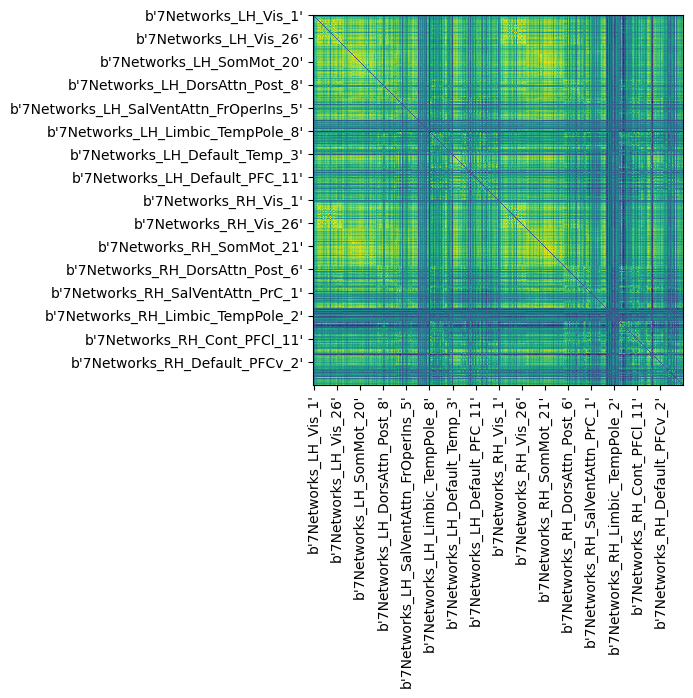

In [35]:
plt.imshow(data2.values.astype(float), interpolation='nearest')
plt.xticks(list(range(0, 400, 25)),[data2.columns.to_list()[i] for i in range(0,400,25)], rotation=90)
plt.yticks(list(range(0, 400, 25)),[data2.columns.to_list()[i] for i in range(0,400,25)], rotation=0)
plt.show()

In [8]:
def extract_all(subj):
    dir_path =Path(f'{data_path}/{subj}/MNINonLinear/Results/')
    dir_path =dir_path if dir_path.exists() else Path(f'{data_path}/{subj}')
    try:
        for dir_name in Path(dir_path).iterdir():
                dir_files =list(dir_name.iterdir())
                if len(dir_files)>0:

                    brain_path = list(dir_name.iterdir())[0]
                    print(brain_path)
                    if brain_path.exists() and not Path(f"results/hcp_rest_schaefer_corrected/{subj}_{dir_name.stem}.csv").exists():

                        corr_dict, data,time_series =extract_correlation_pipe(str(brain_path), atlas)

                        time_series.to_csv(f"results/hcp_rest_schaefer_corrected/{subj}_{dir_name.stem}_embed.csv")
                        data.to_csv(f"results/hcp_rest_schaefer_corrected/{subj}_{dir_name.stem}.csv", index=False)

    except Exception as e: 
        print(e)
                        

In [23]:
subjects =set(subjects_existed) - set(ids)        

In [25]:
len(subjects)/11

27.0

In [26]:
with Pool(11) as p:
    p.map(extract_all, subjects)

/workspace/mnt/public-datasets/m.zubrikhina/hcp_rest2/129331/MNINonLinear/Results/rfMRI_REST1_LR/rfMRI_REST1_LR_hp2000_clean.nii.gz/workspace/mnt/public-datasets/m.zubrikhina/hcp_rest2/937160/MNINonLinear/Results/rfMRI_REST1_LR/rfMRI_REST1_LR_hp2000_clean.nii.gz/workspace/mnt/public-datasets/m.zubrikhina/hcp_rest2/891667/MNINonLinear/Results/rfMRI_REST1_LR/rfMRI_REST1_LR_hp2000_clean.nii.gz/workspace/mnt/public-datasets/m.zubrikhina/hcp_rest2/833249/MNINonLinear/Results/rfMRI_REST1_LR/rfMRI_REST1_LR_hp2000_clean.nii.gz/workspace/mnt/public-datasets/m.zubrikhina/hcp_rest2/120717/MNINonLinear/Results/rfMRI_REST1_LR/rfMRI_REST1_LR_hp2000_clean.nii.gz/workspace/mnt/public-datasets/m.zubrikhina/hcp_rest2/128632/MNINonLinear/Results/rfMRI_REST1_LR/rfMRI_REST1_LR_hp2000_clean.nii.gz/workspace/mnt/public-datasets/m.zubrikhina/hcp_rest2/899885/MNINonLinear/Results/rfMRI_REST1_LR/rfMRI_REST1_LR_hp2000_clean.nii.gz/workspace/mnt/public-datasets/m.zubrikhina/hcp_rest2/163432/MNINonLinear/Results/r

In [27]:
os.listdir('results/hcp_rest_schaefer_corrected/')

['180230_rfMRI_REST1_LR.csv',
 '285446_rfMRI_REST1_LR.csv',
 '200614_rfMRI_REST1_LR.csv',
 '112314_rfMRI_REST1_LR.csv',
 '138231_rfMRI_REST1_LR.csv',
 '132118_rfMRI_REST1_LR_embed.csv',
 '157336_rfMRI_REST1_LR.csv',
 '130316_rfMRI_REST1_LR_embed.csv',
 '873968_rfMRI_REST1_LR_embed.csv',
 '144125_rfMRI_REST1_LR_embed.csv',
 '176239_rfMRI_REST1_LR_embed.csv',
 '249947_rfMRI_REST1_LR_embed.csv',
 '844961_rfMRI_REST1_LR_embed.csv',
 '118932_rfMRI_REST1_LR.csv',
 '145834_rfMRI_REST1_LR.csv',
 '724446_rfMRI_REST1_LR.csv',
 '146634_rfMRI_REST1_LR_embed.csv',
 '163836_rfMRI_REST1_LR_embed.csv',
 '692964_rfMRI_REST1_LR.csv',
 '246133_rfMRI_REST1_LR_embed.csv',
 '103111_rfMRI_REST1_LR.csv',
 '581450_rfMRI_REST1_LR_embed.csv',
 '118730_rfMRI_REST1_LR_embed.csv',
 '580751_rfMRI_REST1_LR_embed.csv',
 '171128_rfMRI_REST1_LR_embed.csv',
 '285446_rfMRI_REST1_LR_embed.csv',
 '188549_rfMRI_REST1_LR.csv',
 '886674_rfMRI_REST1_LR_embed.csv',
 '148335_rfMRI_REST1_LR_embed.csv',
 '118023_rfMRI_REST1_LR.csv'

In [10]:
ids =[]
for dir1 in os.listdir('results/hcp_rest_schaefer_corrected/'):
    id =dir1.split("_")[0]
    ids.append(id)

In [11]:
len(set(ids))

788

In [12]:
#len(os.listdir("results/hcp_data_schaefer"))

In [13]:
count=0
subjects_existed =[]
existed_subjects =set()
for subj in os.listdir(data_path):
            dir_path =Path(f'{data_path}/{subj}/MNINonLinear/Results/')
            dir_path =dir_path if dir_path.exists() else Path(f'{data_path}/{subj}')
            events =list(Path(dir_path).iterdir())
            all_subs=0
            for dir_name in events:
                dir_files =list(dir_name.iterdir())
                if len(dir_files)>0:
                    brain_path = list(dir_name.iterdir())[0]
                    if brain_path.exists():
                        print(brain_path)
                        count+=1
                        subjects_existed.append(subj)
                        all_subs+=1
            print(all_subs)            
            if all_subs>1:       
                existed_subjects.add(subj)


/workspace/mnt/public-datasets/m.zubrikhina/hcp_rest2/779370/MNINonLinear/Results/rfMRI_REST1_LR/rfMRI_REST1_LR_hp2000_clean.nii.gz
1
/workspace/mnt/public-datasets/m.zubrikhina/hcp_rest2/208630/MNINonLinear/Results/rfMRI_REST1_LR/rfMRI_REST1_LR_hp2000_clean.nii.gz
1
/workspace/mnt/public-datasets/m.zubrikhina/hcp_rest2/620434/MNINonLinear/Results/rfMRI_REST1_LR/rfMRI_REST1_LR_hp2000_clean.nii.gz
1
/workspace/mnt/public-datasets/m.zubrikhina/hcp_rest2/287248/MNINonLinear/Results/rfMRI_REST1_LR/rfMRI_REST1_LR_hp2000_clean.nii.gz
1
/workspace/mnt/public-datasets/m.zubrikhina/hcp_rest2/150423/MNINonLinear/Results/rfMRI_REST1_LR/rfMRI_REST1_LR_hp2000_clean.nii.gz
1
/workspace/mnt/public-datasets/m.zubrikhina/hcp_rest2/200311/MNINonLinear/Results/rfMRI_REST1_LR/rfMRI_REST1_LR_hp2000_clean.nii.gz
1
/workspace/mnt/public-datasets/m.zubrikhina/hcp_rest2/453542/MNINonLinear/Results/rfMRI_REST1_LR/rfMRI_REST1_LR_hp2000_clean.nii.gz
1
/workspace/mnt/public-datasets/m.zubrikhina/hcp_rest2/992673/M